In [1]:
# data
import numpy as np
np.random.seed(42)

import torch
from torchvision import datasets, transforms

# (1, 28, 28) for CNN
# some people transform it to have 0 mean and 1 std?
class MNISTtrainer(object):
    def __init__(self, batch_size, input_dim=28*28,val_split=0.1):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split

        train = datasets.MNIST(
                '../data',
                train=True,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ]))

        # split some part of train set to validation
        train_set, val_set = torch.utils.data.random_split(train, [1.-self.val_split, self.val_split])
        self.train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

        self.test_loader = torch.utils.data.DataLoader(
            datasets.MNIST(
                '../data',
                train=False,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ])),
            batch_size=batch_size,
            shuffle=True)

# (1, 28, 28) for CNN
class FashionMNISTtrainer(object):
    def __init__(self, batch_size, input_dim=28*28, val_split=0.1):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split


        train = datasets.FashionMNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        # split some part of train set to validation
        train_set, val_set = torch.utils.data.random_split(train, [1.-self.val_split, self.val_split])
        self.train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
        self.val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

        self.test_loader = torch.utils.data.DataLoader(
            datasets.FashionMNIST(
                '../data',
                train=False,
                download=True,
                transform=transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
                ])),
            batch_size=batch_size,
            shuffle=True)

In [2]:
import numpy as np
np.random.seed(42)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import copy

# init given linear layer m with given sw and sb
def init_weights(m, sw, sb):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, mean=0.0, std=(np.sqrt(sw / m.out_features)))
        nn.init.normal_(m.bias, mean=0.0, std=np.sqrt(sb))

# init new model
# TODO: activation function
# TODO: name the layers
def generate_fc_dnn(input_dim, output_dim, params):
    depth, width = params['depth'], params['width']
    def gen_linear_layer_dim(layer_index):
        return {
            0: (input_dim, width),
            depth - 1: (width, output_dim),
        }.get(layer_index, (width, width))

    fc_list = list()
    for i in range(depth):
        fc_list += [
            nn.Linear(*gen_linear_layer_dim(i)),
            nn.LogSoftmax(dim=1) if (depth - 1 == i) else nn.Tanh()
        ]
    model = nn.Sequential(*fc_list)
    model.apply(lambda m: init_weights(m, params['sw'], params['sb']))
    return model

import torch.nn as nn

'''def generate_cnn(input_dim, output_dim, depth, num_channels):
    layers = []
    in_channels = 1  # Assuming grayscale input images

    # Convolutional layers
    for i in range(depth):
        layers.append(nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1))
        layers.append(nn.Tanh())

        # Add MaxPool2d layer every 2 convolutional layers
        if i % 2 == 1:
            layers.append(nn.MaxPool2d(2))
            input_dim = input_dim // 2
            print("input_dim: ", input_dim)

        in_channels = num_channels
        #num_channels *= 2

    # Flatten the output from convolutional layers
    layers.append(nn.Flatten())

    # Fully connected layer for classification
    layers.append(nn.Linear(in_channels * input_dim * input_dim, output_dim))
    layers.append(nn.LogSoftmax(dim=1))

    model = nn.Sequential(*layers)
    return model
'''

import torch.nn as nn

class CustomCNN(nn.Module):
    def init(self, input_dim, output_dim, depth, num_channels, act_fn, use_pooling=True):
        super(CustomCNN, self).init()
        in_channels = 1  # Assuming grayscale input images
        conv_count = 0

        self.layers = nn.ModuleList()

        for i in range(depth):
            # Add convolutional layer
            self.layers.append(nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1))
            # Add activation layer
            self.layers.append(act_fn())
            conv_count += 1

            # Add MaxPool2d layer every 2 convolutional layers if use_pooling is set
            if use_pooling and i % 2 == 1:
                self.layers.append(nn.MaxPool2d(2))
                input_dim = input_dim // 2
                print("input_dim: ", input_dim)

            in_channels = num_channels
            # num_channels = 2

        # Add fully connected layer for classification
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(in_channels, input_dim * input_dim, output_dim)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.flatten(x)
        x = self.fc(x)
        return self.logsoftmax(x)

def generate_cnn(input_dim, output_dim, depth, num_channels, act_fn=nn.ReLU, use_pooling=True):
    model = CustomCNN(input_dim, output_dim, depth, num_channels, act_fn, use_pooling)
    return model

# dataset_loader is fine-tuning dataset
def eval(model, device, dataset_loader, debug):
    model.eval()
    test_loss, correct = 0., 0.
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(
                dim=1,
                keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.
              format(test_loss, correct, num_data, 100. * acc))

    return acc

# TODO: option to freeze some layers
# TODO: option to save the model?
def compute_training_acc(model, dataset, params, debug=False):
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    # if debug: print(model, optimizer)

    # run training for few steps and return the accuracy
    train_acc = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(dataset.train_loader):
        data, target = data.reshape([data.shape[0],-1]).to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        # Evaluate after every 10 steps epoch
        if debug and batch_idx % 10 == 0:
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            print('Step: {} \tTraining Accuracy: {:.2f}%'.format(batch_idx, train_acc*100))
            # if debug and (epoch+1) % 1 == 0:
            val_acc = eval(model, device, dataset.val_loader, debug=False)
            print('\t\tValidation Accuracy: {:.2f}%'.format(val_acc*100))

    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)
    return train_acc, test_acc, model

# like previous function, but run for given number of epochs determined by params['num_train']
def compute_training_acc_epochs(model, dataset, params, debug=False):
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    # if debug: print(model, optimizer)

    if params['early_stop_patience']:
        no_improve_epochs = 0
        max_val_acc = 0.

    train_acc = 0.0
    model.train()

    # Loop over epochs
    for epoch in range(params['num_train']):
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.reshape([data.shape[0], -1]).to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if debug and batch_idx % 20 == 0:
                #print('Epoch: {} Train step: {} \tLoss: {:.6f}'.format(epoch, batch_idx, loss.item()))
                pass

        # Evaluate after each epoch
        if debug:
            train_acc = eval(model, device, dataset.train_loader, debug=False)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            # if debug and (epoch+1) % 1 == 0:
            val_acc = eval(model, device, dataset.val_loader, debug=False)
            print('Validation Accuracy: {:.2f}%'.format(val_acc*100))

            if params['early_stop_patience']:
                if val_acc > max_val_acc:
                    max_val_acc = val_acc
                    no_improve_epochs = 0
                else:
                    no_improve_epochs += 1
                    print("val_acc: {}, max_val_acc: {}, no_improve_epochs: {}".format(val_acc, max_val_acc, no_improve_epochs))
                    if no_improve_epochs >= params['early_stop_patience']:
                        print("Early stopping invoked.")
                        break

    # Final evaluation after all epochs are completed
    train_acc = eval(model, device, dataset.train_loader, debug=False)
    test_acc = eval(model, device, dataset.test_loader, debug=False)
    return train_acc, test_acc, model

def eval_cnn(model, device, dataset_loader, debug):
    model.eval()
    test_loss, correct = 0., 0.
    with torch.no_grad():
        for data, target in dataset_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data
    if debug:
        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    return acc

def compute_training_acc_epochs_cnn(model, dataset, params, debug=False):
    device = torch.device(params['device'])
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])

    if debug:
        print(model, optimizer)

    train_acc = 0.0
    model.train()

    # Loop over epochs
    for epoch in range(params['num_train']):
        for batch_idx, (data, target) in enumerate(dataset.train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

            if debug and batch_idx % 20 == 0:
                pass

        # Evaluate after each epoch
        if debug:
            train_acc = eval_cnn(model, device, dataset.train_loader, debug=False)
            print('Epoch: {} \tTraining Accuracy: {:.2f}%'.format(epoch, train_acc*100))
            if debug and (epoch+1) % 3 == 0:
                val_acc = eval_cnn(model, device, dataset.val_loader, debug=False)
                print('Validation Accuracy: {:.2f}%'.format(val_acc*100))

    # Final evaluation after all epochs are completed
    train_acc = eval_cnn(model, device, dataset.train_loader, debug=False)
    test_acc = eval_cnn(model, device, dataset.test_loader, debug=False)
    return train_acc, test_acc, model



# cut_point: no. of layers to keep in the model
# reinitialize after cutting point using init_weights function
def cut_model(model, sw = 1, sb = 1, cut_point=1, freeze=True):
    #deepcopy to avoid changing the original model
    model = copy.deepcopy(model)
    # Convert sequential model to list of layers
    layers = list(model.children())

    # Check if cut_point is out of range
    if cut_point < 0 or cut_point >= len(layers) // 2:
        raise ValueError("cut_point should be in range [0, number of layers - 1]")

    # If freeze is True, set requires_grad to False for layers before cut_point
    if freeze:
        for i in range(cut_point):
            for param in layers[2*i].parameters():
                param.requires_grad = False

    # Cut layers
    new_layers = layers[:2*cut_point]

    # Reinitialize layers after cut point
    for i in range(cut_point, len(layers) // 2):
        linear_layer = layers[2*i]
        activation = layers[2*i + 1]

        # Apply initialization
        init_weights(linear_layer, sw, sb)

        # Append to new layers
        new_layers.extend([linear_layer, activation])

    # Return new model
    return nn.Sequential(*new_layers)

def cut_cnn_model(model, cut_point=1, freeze=True):
    """
    Cut the CNN model at a specific layer and reinitialize the weights for layers after cut_point.

    Parameters:
    - model (nn.Module): Original model.
    - cut_point (int): Layer index at which to cut the model.
    - freeze (bool): If True, layers before cut_point will have their weights frozen.

    Returns:
    - new_model (nn.Sequential): Cut and potentially modified model.
    """

    # Deep copy to avoid changing the original model
    model = copy.deepcopy(model)

    # Convert sequential model to list of layers
    layers = list(model.children())

    # Check if cut_point is out of range
    if cut_point < 0 or cut_point >= len(layers):
        raise ValueError("cut_point should be in range [0, number of layers - 1]")

    # If freeze is True, set requires_grad to False for layers before cut_point
    if freeze:
        for i in range(cut_point):
            for param in layers[i].parameters():
                param.requires_grad = False

    # Cut layers
    new_layers = layers[:cut_point]

    # Reinitialize layers after cut point
    for i in range(cut_point, len(layers)):
        layer = layers[i]

        # Reinitialize weights if layer has parameters (like Conv2d)
        if hasattr(layer, 'weight'):
            nn.init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

        # Append to new layers
        new_layers.append(layer)

    # Return new model
    return nn.Sequential(*new_layers)

### Baseline, end to end trained model

In [3]:
batch_size = 256
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'mps'
depth = 100
width = 300

fashion_dataset = FashionMNISTtrainer(batch_size)

# early stopping? False if not needed, otherwise int
params = dict(device=device,
                width=width, lr=1e-3, num_train=100,
                sb=0.05, depth=depth, sw=1.7346938775510203, early_stop_patience=10)

fashion_model = generate_fc_dnn(fashion_dataset.input_dim, fashion_dataset.output_dim,
                params).to(device)

pretrain_acc, pretrain_test_acc, pre_trained_model = compute_training_acc_epochs(fashion_model, fashion_dataset, params, debug=True)
# pretrain_acc, pretrain_test_acc, pre_trained_model = compute_training_acc(fashion_model, fashion_dataset, params, debug=True)


Epoch: 0 	Training Accuracy: 66.87%
Validation Accuracy: 66.82%
Epoch: 1 	Training Accuracy: 71.77%
Validation Accuracy: 71.32%
Epoch: 2 	Training Accuracy: 79.04%
Validation Accuracy: 77.95%
Epoch: 3 	Training Accuracy: 79.08%
Validation Accuracy: 78.53%
Epoch: 4 	Training Accuracy: 81.53%
Validation Accuracy: 80.35%
Epoch: 5 	Training Accuracy: 81.79%
Validation Accuracy: 80.40%
Epoch: 6 	Training Accuracy: 83.10%
Validation Accuracy: 81.72%
Epoch: 7 	Training Accuracy: 82.77%
Validation Accuracy: 81.85%
Epoch: 8 	Training Accuracy: 84.19%
Validation Accuracy: 83.00%
Epoch: 9 	Training Accuracy: 84.25%
Validation Accuracy: 82.75%
val_acc: 0.8275, max_val_acc: 0.83, no_improve_epochs: 1
Epoch: 10 	Training Accuracy: 85.44%
Validation Accuracy: 83.67%
Epoch: 11 	Training Accuracy: 84.74%
Validation Accuracy: 83.17%
val_acc: 0.8316666666666667, max_val_acc: 0.8366666666666667, no_improve_epochs: 1
Epoch: 12 	Training Accuracy: 85.44%
Validation Accuracy: 83.70%
Epoch: 13 	Training Accur

In [36]:
! rm -rf /content/fashion_to_mnist_pretrained

In [5]:
# save the model with hyperparams

import json, os

models_path = "models"
if not os.path.exists(models_path):
    os.mkdir(models_path)

# below choose where you name the new directory
model_path = os.path.join(models_path, "fashion_to_mnist_1")
os.mkdir(model_path)
torch.save(fashion_model.state_dict(), os.path.join(model_path, "pretrained_model.pt"))

params['batch_size'] = batch_size
del params['device']
with open(os.path.join(model_path, "model_params.json"), "w+") as f:
      json.dump(params, f, indent=2, ensure_ascii=False)  # encode dict into JSON

In [11]:
# load the model
models_path = "models"
model_path = os.path.join(models_path, "fashion_to_mnist_1")

with open(os.path.join(model_path, "model_params.json"), "r") as f:
  params = json.load(f)
fashion_model = generate_fc_dnn(fashion_dataset.input_dim, fashion_dataset.output_dim, params)
fashion_model.load_state_dict(torch.load(os.path.join(model_path, "pretrained_model.pt")))
fashion_model.eval()

Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): Tanh()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): Tanh()
  (4): Linear(in_features=300, out_features=300, bias=True)
  (5): Tanh()
  (6): Linear(in_features=300, out_features=300, bias=True)
  (7): Tanh()
  (8): Linear(in_features=300, out_features=300, bias=True)
  (9): Tanh()
  (10): Linear(in_features=300, out_features=300, bias=True)
  (11): Tanh()
  (12): Linear(in_features=300, out_features=300, bias=True)
  (13): Tanh()
  (14): Linear(in_features=300, out_features=300, bias=True)
  (15): Tanh()
  (16): Linear(in_features=300, out_features=300, bias=True)
  (17): Tanh()
  (18): Linear(in_features=300, out_features=300, bias=True)
  (19): Tanh()
  (20): Linear(in_features=300, out_features=300, bias=True)
  (21): Tanh()
  (22): Linear(in_features=300, out_features=300, bias=True)
  (23): Tanh()
  (24): Linear(in_features=300, out_features=300, bias=True)
  (25): Tanh()
  (26): Li

In [13]:
fashion_model.to(device)
eval(fashion_model, device, fashion_dataset.train_loader, debug=False)

0.9456296296296296

### finetuned staring from regular mnist

In [ ]:
#luckily, the number of classes is the same, so we don't need to change the last layer.

number_dataset = MNISTtrainer(batch_size)

cut_models = []

params = dict(device=device,
                width=width, lr=1e-3, num_train=50,
                sb=0.05, depth=depth, sw=1.7346938775510203, early_stop_patience=5)

for cut in range(0, depth, 10):
    temp = {}
    temp['cut_model'] = cut_model(fashion_model, sw = 1.5, sb = 1, cut_point = cut)
    finetuned_acc, finetuned_test_acc, finetuned_model = compute_training_acc_epochs(temp['cut_model'], number_dataset, params, debug=False)
    temp['finetuned_acc'] = finetuned_acc
    temp['finetuned_test_acc'] = finetuned_test_acc
    temp['finetuned_model'] = finetuned_model
    cut_models.append(temp)

In [ ]:
from pprint import pprint

for i, mod in enumerate(cut_models):
    print(f"Cut {i}:")
    pprint(mod['finetuned_acc'])

Cut 0:
0.6980185185185185
Cut 1:
0.6325185185185185
Cut 2:
0.5967407407407408
Cut 3:
0.4776666666666667
Cut 4:
0.48144444444444445
Cut 5:
0.43337037037037035
Cut 6:
0.39785185185185185
Cut 7:
0.3872037037037037
Cut 8:
0.37405555555555553
Cut 9:
0.2746851851851852


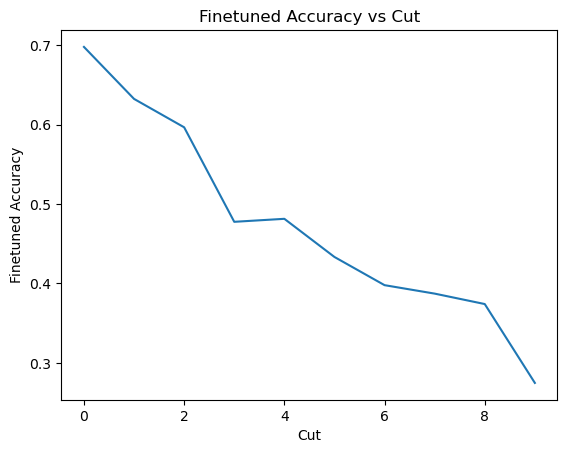

In [ ]:
import matplotlib.pyplot as plt

finetuned_accs = [model['finetuned_acc'] for model in cut_models]
cuts = range(len(finetuned_accs))
plt.plot(cuts, finetuned_accs)
plt.xlabel('Cut')
plt.ylabel('Finetuned Accuracy')
plt.title('Finetuned Accuracy vs Cut')
plt.show()

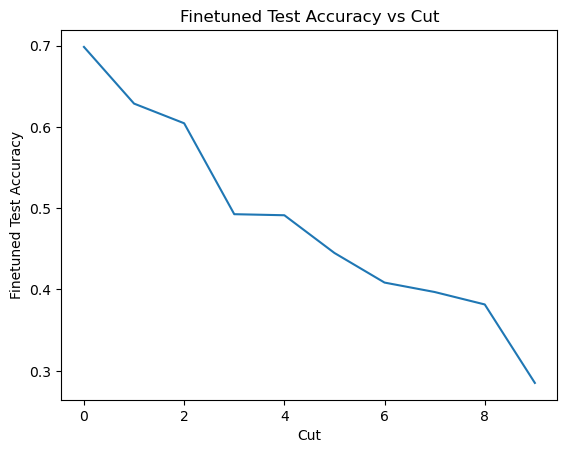

In [ ]:
import matplotlib.pyplot as plt

finetuned_test_accs = [model['finetuned_test_acc'] for model in cut_models]
cuts = range(len(finetuned_test_accs))
plt.plot(cuts, finetuned_test_accs)
plt.xlabel('Cut')
plt.ylabel('Finetuned Test Accuracy')
plt.title('Finetuned Test Accuracy vs Cut')
plt.show()

----